In [1]:
import os
import json
import copy
import typing

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
import scipy
import scipy.signal

from utils.image_processing import *


with open("./images/tasks.json", "r") as task_imglist_file:
    TASK_IMGLIST = json.load(task_imglist_file)
    
IMAGES = {}
for task in TASK_IMGLIST:
    for img_name in TASK_IMGLIST[task]:
        IMAGES[img_name] = cv.imread('./images/' + img_name, cv.IMREAD_GRAYSCALE)
        
BINARIZED_IMAGES = {}
CONNECTED_COMPONENTS = {}

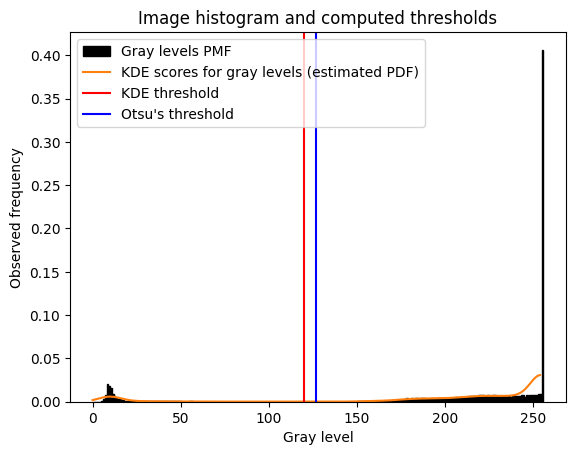

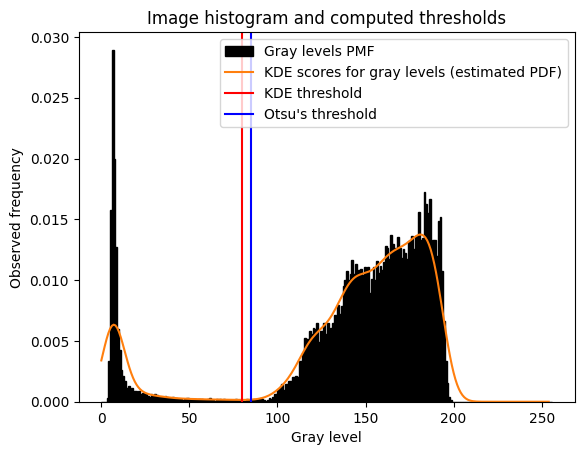

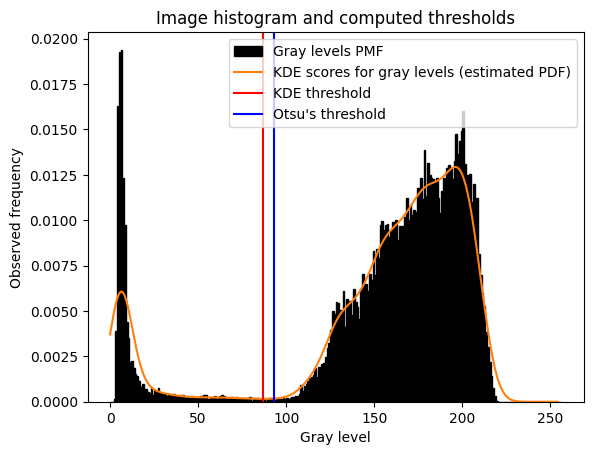

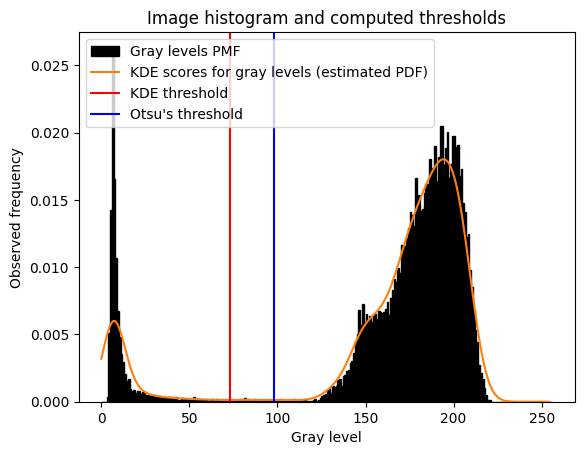

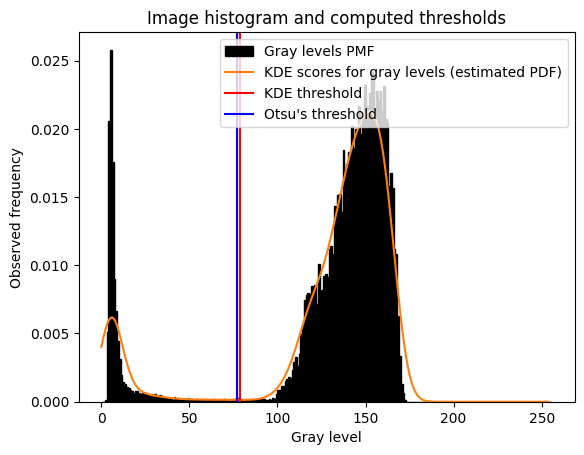

In [2]:
for img_name in TASK_IMGLIST['TASK_1']:
    X = np.arange(255)[:, None]
    kde = KernelDensity(kernel='gaussian', bandwidth=6).fit(IMAGES[img_name].ravel()[:, None])
    log_dens = kde.score_samples(X)
    threshold = scipy.signal.argrelmin(log_dens)[0][0]
    otsu_threshold, _ = cv.threshold(IMAGES[img_name], 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    plt.hist(IMAGES[img_name].ravel(), bins=256, range=(0, 256), density=True, fc='k', ec='k', label='Gray levels PMF') #calculating histogram
    plt.plot(np.exp(log_dens), label='KDE scores for gray levels (estimated PDF)')
    plt.axvline(x=threshold, color='red', label='KDE threshold')
    plt.axvline(x=otsu_threshold, color='blue', label='Otsu\'s threshold')
    plt.xlabel('Gray level')
    plt.ylabel('Observed frequency')
    plt.title('Image histogram and computed thresholds')
    plt.legend()
    plt.show()

## FIRST TASK ##

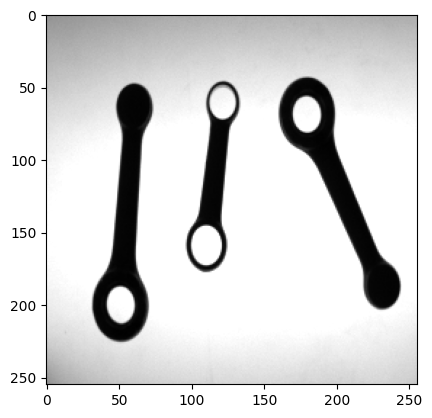

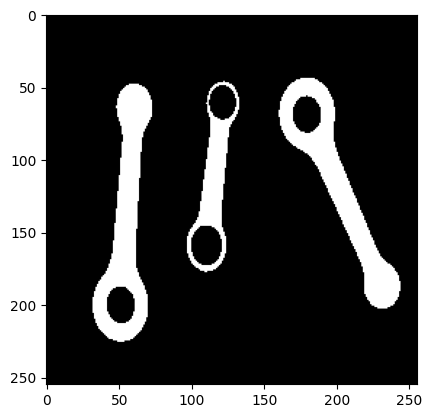

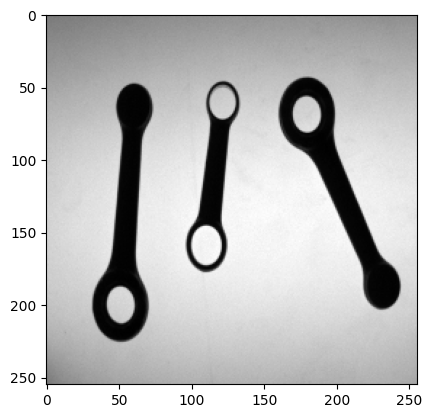

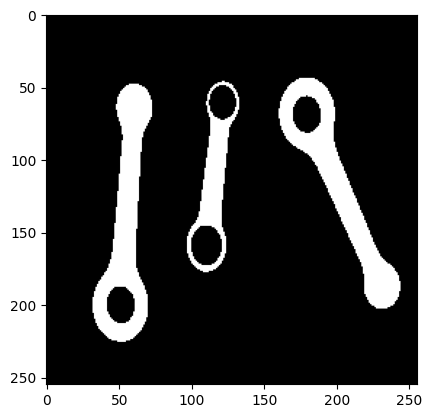

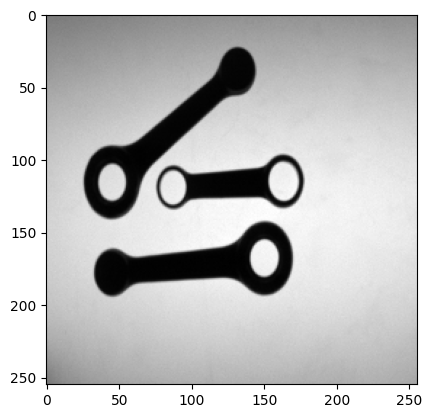

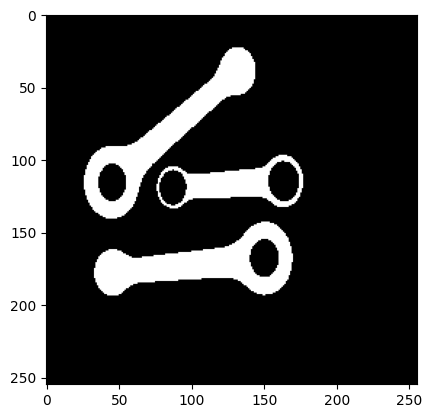

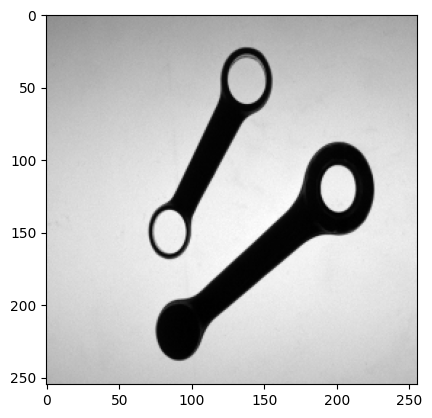

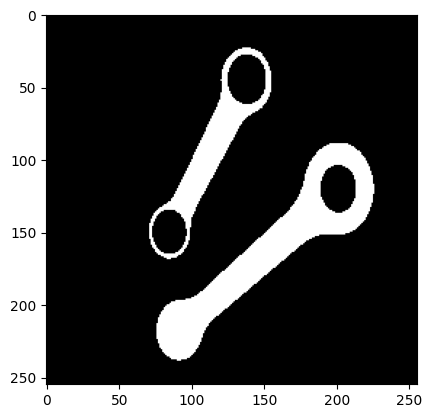

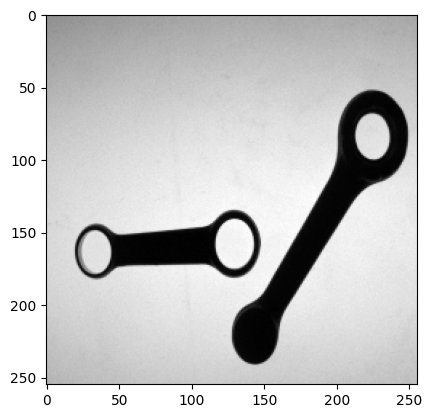

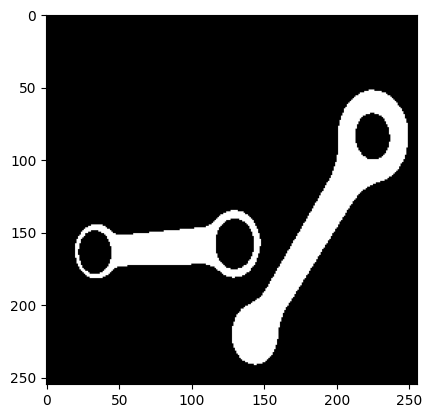

In [3]:
for img_name in TASK_IMGLIST['TASK_1']:
    threshold, binarized_img = binarizeImage(IMAGES[img_name], kde_bandwidth=6)
    BINARIZED_IMAGES[img_name] = binarized_img
    plt.imshow(IMAGES[img_name], cmap="gray")
    plt.show()
    plt.imshow(binarized_img, cmap="gray")
    plt.show()

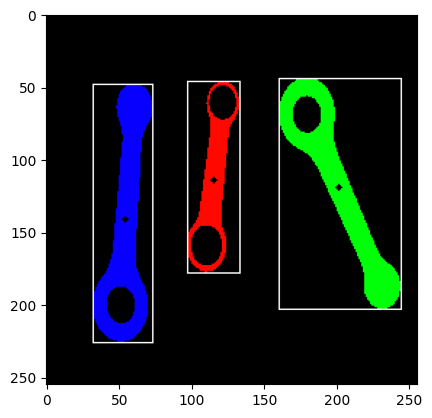

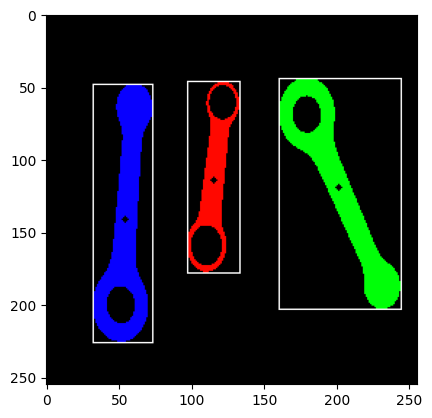

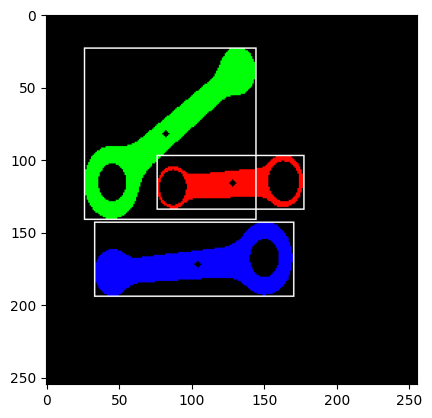

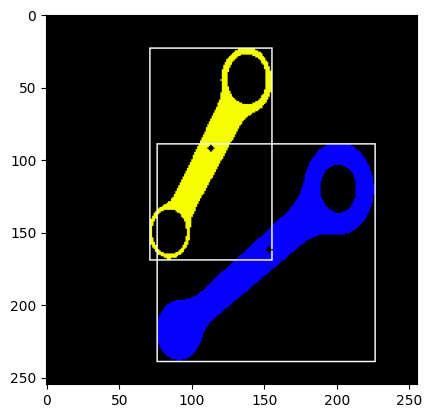

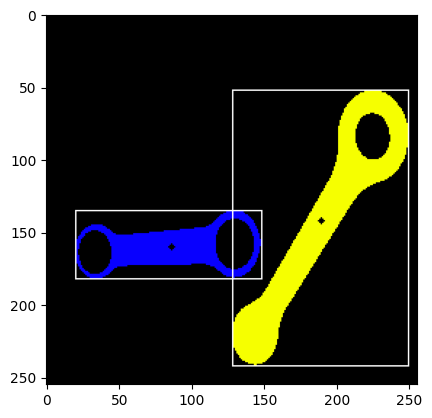

In [4]:
for img_name in TASK_IMGLIST['TASK_1']:
    n_labels, label_ids, stats, centroids = cv.connectedComponentsWithStats(BINARIZED_IMAGES[img_name], connectivity=4)
    CONNECTED_COMPONENTS[img_name] = (n_labels, label_ids, stats, centroids)
    plot_connected_components(n_labels, label_ids, stats, centroids)

In [19]:
def getCCMask(labels, label):
    mask = np.zeros_like(labels, dtype=np.uint8)
    mask[labels == label] = 255
    return mask

def getMoment(mask: np.ndarray, order: typing.Tuple[int,int], barycenter: typing.Tuple[int, int] = (0,0)) -> int:
    i, j = np.where(mask)
    return np.sum(((i - barycenter[0]) ** order[0]) * ((j - barycenter[1]) ** order[1]))

def getAngleAndAxes(mask: np.ndarray, blob_area: int):
    i_b, j_b = (getMoment(mask, (1,0)), getMoment(mask, (0,1))) / blob_area
    m_0_2 = getMoment(mask, (0,2), barycenter=(i_b,j_b))
    m_2_0 = getMoment(mask, (2,0), barycenter=(i_b,j_b))
    m_1_1 = getMoment(mask, (1,1), barycenter=(i_b,j_b))
    
    theta = -0.5 * np.arctan(2 * m_1_1 / (m_0_2 - m_2_0)) + np.pi / 2
    second_derivative = 2 * (m_0_2 - m_2_0) * np.cos(2 * theta) - 4 * m_1_1 * np.sin(2 * theta)
    if second_derivative < 0:
        theta -= np.pi / 2
        
    alpha = -np.sin(theta)
    beta = np.cos(theta)
    
    a = alpha
    b = -beta
    c = beta * i_b - alpha * j_b
    
    a_prime = beta
    b_prime = alpha
    c_prime = -beta * j_b - alpha * i_b
    
    return (theta, (a, b, c), (a_prime, b_prime, c_prime))

def findMER(major_axis: typing.Tuple[float,float,float], minor_axis: typing.Tuple[float,float,float], edges: np.ndarray):
    dMAmin = np.inf
    dMImin = np.inf
    dMAmax = -np.inf
    dMImax = -np.inf
    normMA = np.sqrt(major_axis[0] * major_axis[0] + major_axis[1] * major_axis[1])
    normMI = np.sqrt(minor_axis[0] * minor_axis[0] + minor_axis[1] * minor_axis[1])
    C1 = np.zeros((2,), dtype=np.int32)
    C2 = np.zeros((2,), dtype=np.int32)
    C3 = np.zeros((2,), dtype=np.int32)
    C4 = np.zeros((2,), dtype=np.int32)
    V1 = np.zeros((2,), dtype=np.int32)
    V2 = np.zeros((2,), dtype=np.int32)
    V3 = np.zeros((2,), dtype=np.int32)
    V4 = np.zeros((2,), dtype=np.int32)
    
    for i in range(edges.shape[0]):
        dMA = (major_axis[0] * edges[i][0][0] + major_axis[1] * edges[i][0][1] + major_axis[2]) /  normMA
        dMI = (minor_axis[0] * edges[i][0][0] + minor_axis[1] * edges[i][0][1] + minor_axis[2]) /  normMI
        if dMA < dMAmin:
            dMAmin = dMA
            C1[0] = edges[i][0][0]
            C1[1] = edges[i][0][1]
        elif dMA > dMAmax:
            dMAmax = dMA
            C2[0] = edges[i][0][0]
            C2[1] = edges[i][0][1]
        if dMI < dMImin:
            dMImin = dMI
            C3[0] = edges[i][0][0]
            C3[1] = edges[i][0][1]
        elif dMI > dMImax:
            dMImax = dMI
            C4[0] = edges[i][0][0]
            C4[1] = edges[i][0][1]
    
    c_l_1 = -(major_axis[0] * C1[0] + major_axis[1] * C1[1])
    c_l_2 = -(major_axis[0] * C2[0] + major_axis[1] * C2[1])
    c_w_1 = -(minor_axis[0] * C3[0] + minor_axis[1] * C3[1])
    c_w_2 = -(minor_axis[0] * C4[0] + minor_axis[1] * C4[1])
    
    V1[0] = np.ceil((major_axis[1] * c_w_1 - minor_axis[1] * c_l_1) / (major_axis[0] * minor_axis[1] - major_axis[1] * minor_axis[0]))
    V2[0] = np.ceil((major_axis[1] * c_w_2 - minor_axis[1] * c_l_1) / (major_axis[0] * minor_axis[1] - major_axis[1] * minor_axis[0]))
    V3[0] = np.ceil((major_axis[1] * c_w_1 - minor_axis[1] * c_l_2) / (major_axis[0] * minor_axis[1] - major_axis[1] * minor_axis[0]))
    V4[0] = np.ceil((major_axis[1] * c_w_2 - minor_axis[1] * c_l_2) / (major_axis[0] * minor_axis[1] - major_axis[1] * minor_axis[0]))
    
    V1[1] = np.ceil((minor_axis[0] * c_l_1 - major_axis[0] * c_w_1) / (major_axis[0] * minor_axis[1] - major_axis[1] * minor_axis[0]))
    V2[1] = np.ceil((minor_axis[0] * c_l_1 - major_axis[0] * c_w_2) / (major_axis[0] * minor_axis[1] - major_axis[1] * minor_axis[0]))
    V3[1] = np.ceil((minor_axis[0] * c_l_2 - major_axis[0] * c_w_1) / (major_axis[0] * minor_axis[1] - major_axis[1] * minor_axis[0]))
    V4[1] = np.ceil((minor_axis[0] * c_l_2 - major_axis[0] * c_w_2) / (major_axis[0] * minor_axis[1] - major_axis[1] * minor_axis[0]))
    
    return V1, V2, V3, V4, C1, C2, C3, C4

def getWidthAtBarycenter(edges: np.ndarray, minor_axis: typing.Tuple[int, int, int], major_axis: typing.Tuple[int, int, int]):
    points_placement_wrt_major_axis = edges[:,:,0] * major_axis[0] + edges[:,:,1] * major_axis[1] + major_axis[2]
    contour_points_distance_from_minor_axis = np.abs(edges[:,:,0] * minor_axis[0] + edges[:,:,1] * minor_axis[1] + minor_axis[2]) / np.sqrt(minor_axis[0] ** 2 + minor_axis[1] ** 2)
    left_indexes = np.where(points_placement_wrt_major_axis < 0)[0]
    right_indexes = np.where(points_placement_wrt_major_axis >= 0)[0]
    left_extreme = edges[left_indexes[np.argmin(contour_points_distance_from_minor_axis[left_indexes])]]
    right_extreme = edges[right_indexes[np.argmin(contour_points_distance_from_minor_axis[right_indexes])]]
    
    return np.linalg.norm(left_extreme - right_extreme), left_extreme, right_extreme

def getHoleCenterAndDiameter(hole_contour: np.ndarray):
    center, _, _ = cv.fitEllipse(hole_contour)
    area = cv.contourArea(hole_contour)
    radius = np.sqrt(area / np.pi)
    
    return center, 2 * radius

TESI00.BMP
The rod labeled 1 in the image TESI00.BMP is of type A
Its barycenter is at position [119.10483871 201.37531017], it has an orientation angle of 113.21 degrees, its length is 168.47, its width is 39.92, and its width at the barycenter is 15.23


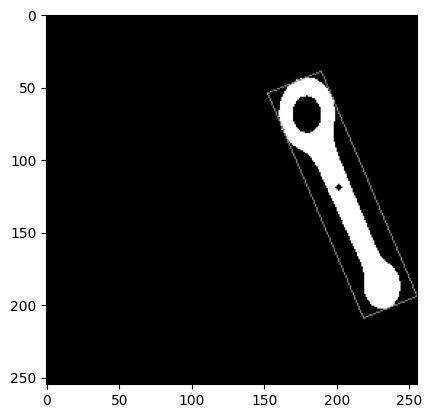

The rod labeled 2 in the image TESI00.BMP is of type B
Its barycenter is at position [114.29904632 115.21117166], it has an orientation angle of 83.40 degrees, its length is 130.86, its width is 27.17, and its width at the barycenter is 14.04


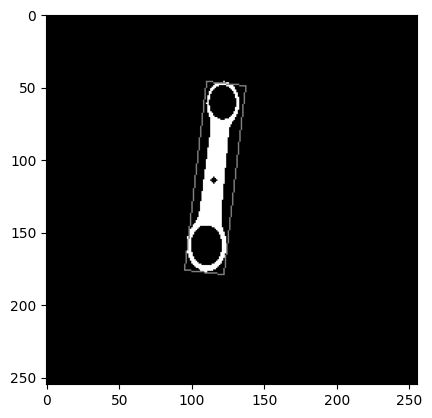

The rod labeled 3 in the image TESI00.BMP is of type A
Its barycenter is at position [141.32237246  54.83159189], it has an orientation angle of 85.97 degrees, its length is 177.48, its width is 38.12, and its width at the barycenter is 14.04


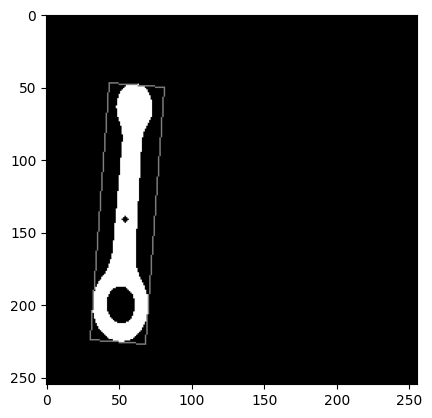

TESI01.BMP
The rod labeled 1 in the image TESI01.BMP is of type A
Its barycenter is at position [119.11866502 201.3461063 ], it has an orientation angle of 113.20 degrees, its length is 168.47, its width is 39.92, and its width at the barycenter is 15.23


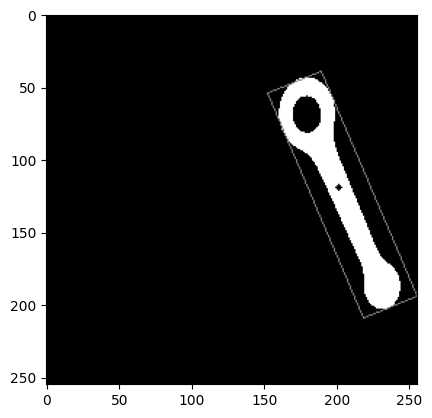

The rod labeled 2 in the image TESI01.BMP is of type B
Its barycenter is at position [114.33063428 115.16531714], it has an orientation angle of 83.50 degrees, its length is 131.86, its width is 27.17, and its width at the barycenter is 14.04


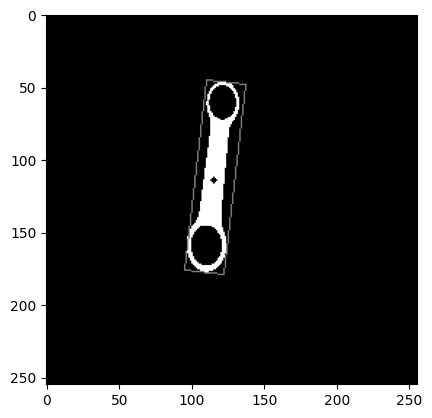

The rod labeled 3 in the image TESI01.BMP is of type A
Its barycenter is at position [141.29555896  54.80704441], it has an orientation angle of 85.99 degrees, its length is 177.48, its width is 38.12, and its width at the barycenter is 14.04


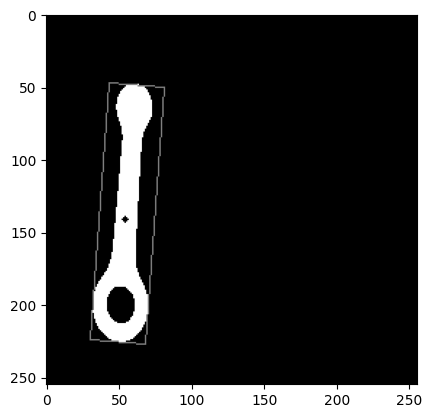

TESI12.BMP
gotcha
The rod labeled 1 in the image TESI12.BMP is of type A
Its barycenter is at position [82.11927452 82.30187519], it has an orientation angle of 42.02 degrees, its length is 152.23, its width is 44.60, and its width at the barycenter is 16.97


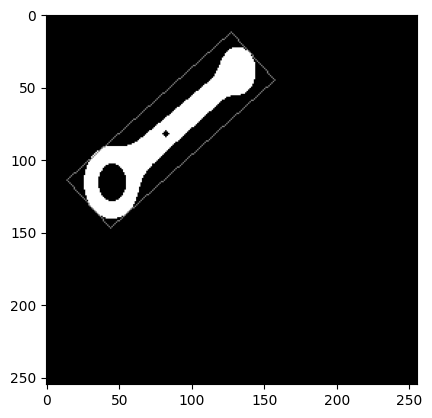

gotcha
The rod labeled 2 in the image TESI12.BMP is of type B
Its barycenter is at position [116.59218643 128.66826594], it has an orientation angle of 3.43 degrees, its length is 101.18, its width is 35.06, and its width at the barycenter is 17.03


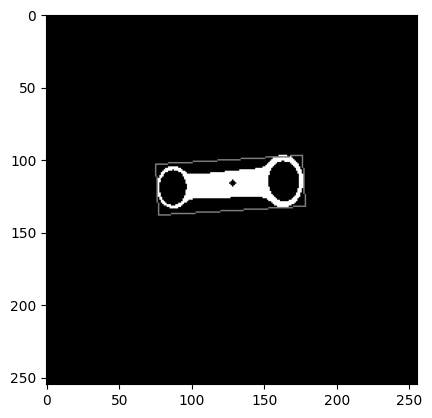

gotcha
The rod labeled 3 in the image TESI12.BMP is of type A
Its barycenter is at position [172.2095679  104.61388889], it has an orientation angle of 5.36 degrees, its length is 136.62, its width is 49.25, and its width at the barycenter is 19.10


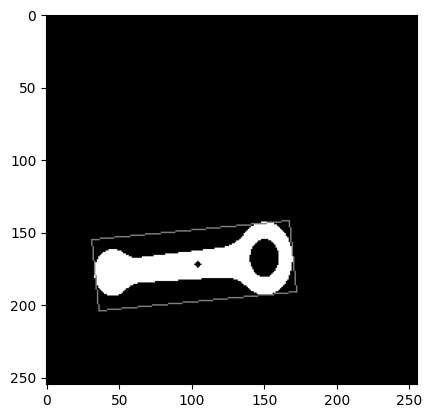

TESI21.BMP
The rod labeled 1 in the image TESI21.BMP is of type B
Its barycenter is at position [ 92.11096829 113.89760069], it has an orientation angle of 63.54 degrees, its length is 155.18, its width is 36.67, and its width at the barycenter is 17.89


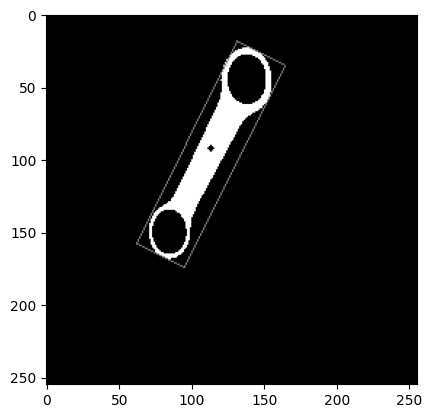

gotcha
The rod labeled 2 in the image TESI21.BMP is of type A
Its barycenter is at position [162.29849595 153.34168916], it has an orientation angle of 42.18 degrees, its length is 192.59, its width is 56.64, and its width at the barycenter is 21.93


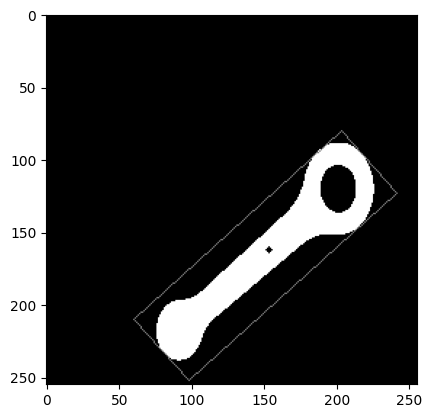

TESI31.BMP
The rod labeled 1 in the image TESI31.BMP is of type A
Its barycenter is at position [142.9026801  189.45466641], it has an orientation angle of 59.57 degrees, its length is 208.03, its width is 51.97, and its width at the barycenter is 19.72


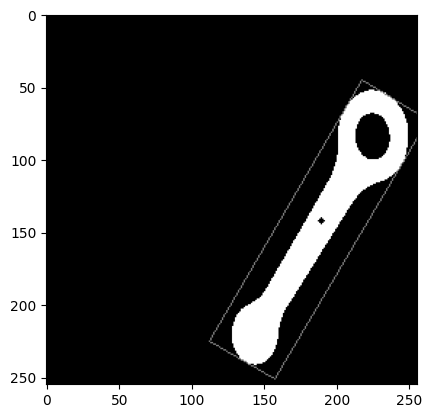

gotcha
The rod labeled 2 in the image TESI31.BMP is of type B
Its barycenter is at position [160.18032112  86.20008234], it has an orientation angle of 3.12 degrees, its length is 127.19, its width is 46.10, and its width at the barycenter is 23.02


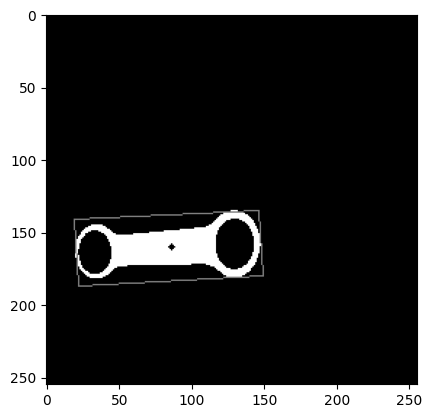

In [17]:
for img_name in TASK_IMGLIST['TASK_1']:
    print(img_name)
    n_labels, label_ids, stats, centroids = CONNECTED_COMPONENTS[img_name]
    for label in range(1, n_labels):
        mask = getCCMask(label_ids, label)
        contours, hierarchy = cv.findContours(mask, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)
        rod_barycenter = (getMoment(mask, (1,0)), getMoment(mask, (0,1))) / stats[label][-1]
        (theta, (a, b, c), (a_prime, b_prime, c_prime)) = getAngleAndAxes(mask, stats[label][-1])
        V1, V2, V3, V4, C1, C2, C3, C4 = findMER((a, b, c), (a_prime, b_prime, c_prime), contours[0])
        length = np.linalg.norm(V1 - V2)
        width = np.linalg.norm(V1 - V3)
        angle_deg = np.degrees(theta)
        barycenter_width, point_A, point_B = getWidthAtBarycenter(contours[0], (a_prime, b_prime, c_prime), (a,b,c))
        rod_type = "A" if len(contours) == 2 else "B"
        print("The rod labeled %d in the image %s is of type %s" % (label, img_name, rod_type))
        print("Its barycenter is at position %s, it has an orientation angle of %.2f degrees, its length is %.2f, its width is %.2f, and its width at the barycenter is %.2f" \
              % (str(rod_barycenter), angle_deg, length, width, barycenter_width))
        cv.circle(mask, (int(rod_barycenter[1]), int(rod_barycenter[0])), radius=2, color=(0, 0, 0), thickness=-1)
        cv.drawContours(mask, np.array([[V2, V4, V3, V1]]), contourIdx=0, color=(128,128,128), thickness=1)
        plt.imshow(mask, cmap="gray")
        plt.show()